In [4]:
import tensorflow as tf
import os
import random
import pylab
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image

In [10]:
DATA_FOLDER = '/home/ankdesh/explore/DeepLearning-UdacityCapston/data/FullImageDataSet/train_sample'
TFRECORDFILENAME = 'train_sample'

In [89]:
IMG_SIZE = 100 # Side for each transformed Image
IMG_DEPTH = 3 # RGB files

In [90]:
''' Code from Hang_Yao at https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657/5'''
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']
        self.fileMap = {} # Map from File name to BBox Info

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox
    
    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s
# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'bbox' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        for i in range(len(pictDat)):
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            self.fileMap[pictDat[i]["name"]] = figures
        return self.fileMap

In [91]:
matFile = os.path.join(DATA_FOLDER, 'digitStruct.mat')
dsf = DigitStructFile(matFile)
train_data = dsf.getAllDigitStructure_ByDigit()

In [92]:
print train_data['1.png']

[{'width': 81.0, 'top': 77.0, 'label': 1.0, 'left': 246.0, 'height': 219.0}, {'width': 96.0, 'top': 81.0, 'label': 9.0, 'left': 323.0, 'height': 219.0}]


In [99]:
def getNumPngFiles(dirName):
    return len(glob.glob(dirName + '/*.png'))
def getNextImage(dirName):
    allFileNames = glob.glob(dirName + '/*.png')
    random.shuffle(allFileNames)
    for imgFile in allFileNames:
        img = Image.open(imgFile)
        labels = [int(x['label']) for x in train_data[os.path.split(imgFile)[1]]]
        img = img.resize((IMG_SIZE,IMG_SIZE), resample = (Image.BILINEAR))
        #my_img = tf.image.decode_png(imgFile)
        yield (np.asarray(img),labels)

[1, 8, 7]


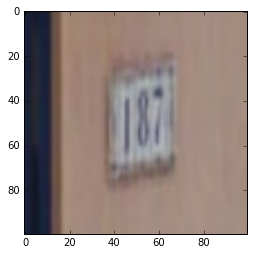

In [100]:
%matplotlib inline
asd = getNextImage(DATA_FOLDER).next()
print asd[1]
plt.imshow(asd[0])

In [107]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [110]:
def writeRecordFile(fileName):
  fileName = os.path.join(fileName + '.tfrecords')
  print('Writing to ...', fileName)
  writer = tf.python_io.TFRecordWriter(fileName)
  for i in range(getNumPngFiles(DATA_FOLDER)):
    image_raw,labels = getNextImage(DATA_FOLDER).next()
    image_raw = image_raw.tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(IMG_SIZE),
        'width': _int64_feature(IMG_SIZE),
        'depth': _int64_feature(IMG_DEPTH),
        'label0': _int64_feature(labels[0]) if len(labels) > 0 else _int64_feature(127), 
        'label1': _int64_feature(labels[1]) if len(labels) > 1 else _int64_feature(127),
        'label2': _int64_feature(labels[2]) if len(labels) > 2 else _int64_feature(127),
        'label3': _int64_feature(labels[3]) if len(labels) > 3 else _int64_feature(127), 
        'label4': _int64_feature(labels[4]) if len(labels) > 4 else _int64_feature(127), 
        'label5': _int64_feature(labels[5]) if len(labels) > 5 else _int64_feature(127), 
        'label6': _int64_feature(labels[6]) if len(labels) > 6 else _int64_feature(127), 
        'image_raw': _bytes_feature(image_raw)}))
    writer.write(example.SerializeToString())

In [111]:
writeRecordFile(TFRECORDFILENAME)

('Writing to ...', 'train_sample.tfrecords')
